# Why's My Airplane Late?

COVID has finally started slowing down with people going out without any face masks, partying at some tightly closed place while Dua Lipa's Levitate is being played really loudly, and some are even planning to travel. But one thing that's really problematic about airports are delayed flights. Everybody hates them and it somehow tries to track you and let you stay at the airport for an additional hour. Now let's see how we can minimize the chances of a delayed flight.

Do take note that I only focused on [mainline passenger airlines](https://en.wikipedia.org/wiki/Major_airlines_of_the_United_States). So if any of you here, ride a bomber airplane to your destination, sorry bro, don't even bother reading this.

In [1]:
#import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

#load data
major_airlines = pd.read_csv("final.csv")

## Can someone please tell me when the airplane will arrive?

In [2]:
major_airlines.groupby(["DEP_DEL15", "ARR_DEL15"]).size()

DEP_DEL15  ARR_DEL15
0.0        0.0          2437701
1.0        1.0           606913
dtype: int64

Sad to say but when your flight departure is late by atleast 15 minutes, it is guaranteed you will arrive late regardless of destination.

In [3]:
#departed late
dep_delay = major_airlines.groupby("ORIGIN_AIRPORT").agg({"DEP_DEL15": ["count", "sum"]}).reset_index()
dep_delay.columns = ["Airport", "Total Flights", "Delayed Flight"]

dep_delay["% Delayed Flight"] = dep_delay["Delayed Flight"]/dep_delay["Total Flights"]*100

#arrived late
arr_delay = major_airlines.groupby("DEST_AIRPORT").agg({"ARR_DEL15": ["count", "sum"]}).reset_index()
arr_delay.columns = ["Airport", "Total Flights", "Delayed Flights"]

arr_delay["% Arrived Late"] = arr_delay["Delayed Flights"]/arr_delay["Total Flights"]*100

#merged dataset
late_flights = dep_delay[["Airport", "% Delayed Flight"]].merge(arr_delay[["Airport", "% Arrived Late"]], on = "Airport")

In [4]:
print("In average {:.2f}% of flights departed late. While {:.2f}% of the flight did not arrive on time.".format(dep_delay["% Delayed Flight"].mean(),
                                                                                                arr_delay["% Arrived Late"].mean()))

In average 19.39% of flights departed late. While 19.72% of the flight did not arrive on time.


In [5]:
dep_delmin = major_airlines.groupby(["ORIGIN_AIRPORT", "DEP_DEL15"]).agg({"DEP_DELAY":"median"}).reset_index()
arr_delmin = major_airlines.groupby(["DEST_AIRPORT", "ARR_DEL15"]).agg({"ARR_DELAY":"median"}).reset_index()

print("On average, when a flight is delayed, expect to arrive by {:.0f} minutes more than your scheduled flight arrival time."\
      .format(arr_delmin[arr_delmin["ARR_DEL15"] == 1]["ARR_DELAY"].median()))

On average, when a flight is delayed, expect to arrive by 39 minutes more than your scheduled flight arrival time.


## Why are the flights delayed?

In [6]:
del_reason = major_airlines[major_airlines["DEP_DEL15"] == 1][["DEP_DELAY", "ARR_DELAY","CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"]]

del_reason["CARRIER_encode"] = np.where(del_reason["CARRIER_DELAY"] > 0, 1, 0)
del_reason["WEATHER_encode"] = np.where(del_reason["WEATHER_DELAY"] > 0, 1, 0)
del_reason["NAS_encode"] = np.where(del_reason["NAS_DELAY"] > 0, 1, 0)
del_reason["SECURITY_encode"] = np.where(del_reason["SECURITY_DELAY"] > 0, 1, 0)
del_reason["LATE_AIRCRAFT_encode"] = np.where(del_reason["LATE_AIRCRAFT_DELAY"] > 0, 1, 0)

In [7]:
reason = ["Carrier", "Weather", "NAS", "Security", "Late Aircraft"]
percentage = [del_reason["CARRIER_encode"].sum()/del_reason.shape[0]*100,
             del_reason["WEATHER_encode"].sum()/del_reason.shape[0]*100,
             del_reason["NAS_encode"].sum()/del_reason.shape[0]*100,
             del_reason["SECURITY_encode"].sum()/del_reason.shape[0]*100,
             del_reason["LATE_AIRCRAFT_encode"].sum()/del_reason.shape[0]*100]

dataframe = {"Reason":reason, "Percentage":percentage}

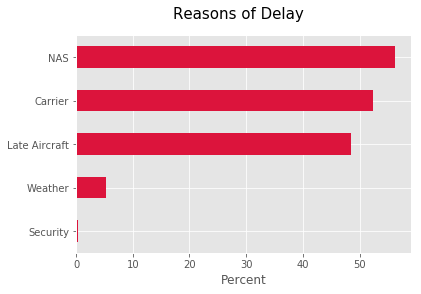

In [8]:
pd.DataFrame.from_dict(dataframe).sort_values("Percentage").plot(kind = "barh", 
                                                            y = "Percentage", x = "Reason", 
                                                            legend = False, color = ["crimson"])
plt.ylabel("")
plt.xlabel("Percent")
plt.suptitle("Reasons of Delay", fontsize = 15);

There are 3 main reasons why the flight is delayed which are the following:

1. National Aviation System (NAS) - Localized problems of the airport 
    1. Non-extreme weather conditions
    2. Airport operations
    3. Heavy traffic volume
    4. Air traffic control
2. Carrier - anything related to the airline
    1. Maintenance
    2. Crew Problems
    3. Aircraft cleaning
    4. Baggage loading
    5. Fueling
3. Late aircraft - the airplane arrived longer than expected

Given that these problems can happen simulataneously, there's not much we can do as passengers. But one thing we can control of is the airline and the time!

## Which time can we minimize delays?

In [9]:
def risk_category(dataframe, percent_delay):
    condlist = [dataframe[percent_delay] < 12,
           (dataframe[percent_delay] >= 12) & (dataframe[percent_delay] < 20),
           dataframe[percent_delay] >= 20]
    choicelist = [1,2,3]

    return np.select(condlist, choicelist)


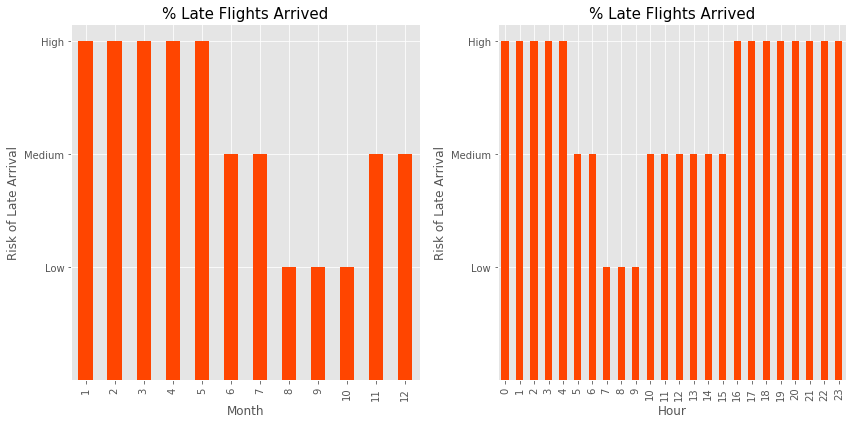

In [10]:
#hour
hour_delay = major_airlines.groupby("CRS_ARR_HOUR").agg({"ARR_DEL15":["sum"], "DEP_DEL15":["sum"], "CRS_ARR_HOUR":["count"]}).reset_index()
hour_delay.columns = ["CRS_ARR_HOUR", "ARR DEL FLIGHTS", "DEP DEL FLIGHTS", "TOTAL FLIGHTS"]

hour_delay["% Late Flights"] = hour_delay["DEP DEL FLIGHTS"]/hour_delay["TOTAL FLIGHTS"]*100

hour_delay["late category"] = risk_category(hour_delay, "% Late Flights") #categorize % late by category

#month
month_delay = major_airlines.groupby("ARR_MONTH").agg({"ARR_DEL15":["sum"], "DEP_DEL15":["sum"], "CRS_ARR_HOUR":["count"]}).reset_index()
month_delay.columns = ["ARR_MONTH", "ARR DEL FLIGHTS", "DEP DEL FLIGHTS", "TOTAL FLIGHTS"]

month_delay["% Late Flights"] = hour_delay["DEP DEL FLIGHTS"]/hour_delay["TOTAL FLIGHTS"]*100

#categorize % late by category
month_delay["late category"] = risk_category(month_delay, "% Late Flights")

#plotting
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =  (12, 6))

month_delay.plot(kind = "bar", x = "ARR_MONTH", y = "late category", 
                color = 'orangered', legend = False, ax = ax1)

ax1.set_title("% Late Flights Arrived", fontsize = 15)
ax1.set_ylabel("Risk of Late Arrival")
ax1.set_xlabel("Month")
ax1.set_yticks([1,2,3])
ax1.set_yticklabels(["Low", "Medium", "High"])


hour_delay.plot(kind = "bar", x = "CRS_ARR_HOUR", y = "late category", 
                color = 'orangered', legend = False, ax = ax2)

ax2.set_title("% Late Flights Arrived", fontsize = 15)
ax2.set_ylabel("Risk of Late Arrival")
ax2.set_xlabel("Hour")
ax2.set_yticks([1,2,3])
ax2.set_yticklabels(["Low", "Medium", "High"])


plt.tight_layout()

I've categorized the risk of late arrival as follows:
1. If the percentage of late arrivals are above 20% then it's considered high
2. Anything between 15% but less than 20% is medium.
3. Anything less than 12% is low risk.

Buying a ticket during August to October, generally has low risk of late arrival, and you can further minimize that when schedule your flight between 7AM and 9AM.

## Which airline to pick?

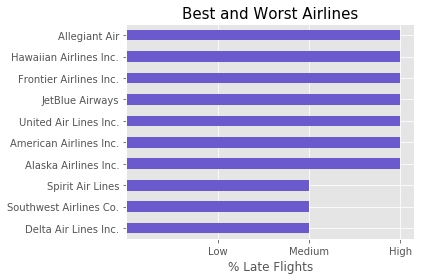

In [11]:
#best and worst airlines
passenger_airlines = major_airlines.groupby("Description").agg({"ARR_DEL15":["count","sum"]}).reset_index()
passenger_airlines.columns = ["Airline", "Total Flights", "Late Flights"]

passenger_airlines["% Late Flights"] = passenger_airlines["Late Flights"]/passenger_airlines["Total Flights"]*100
passenger_airlines["late category"] = risk_category(passenger_airlines, "% Late Flights")


passenger_airlines.sort_values("% Late Flights").plot(kind = "barh", x = "Airline", y = "late category",
                                                      legend = False, color = "slateblue")

plt.xticks([1,2,3], ["Low", "Medium", "High"])
plt.ylabel("")
plt.xlabel("% Late Flights")
plt.title("Best and Worst Airlines", fontsize = 15)

plt.tight_layout()

You may save a lot from Allegiant Air, and Frontier Airlines, but it sacrifices a lot by being late by more than 25% of the time! Trash on Delta Airlines all you want, with its seats made for babies, but at least they arrive on time.

## How is the airport doing?

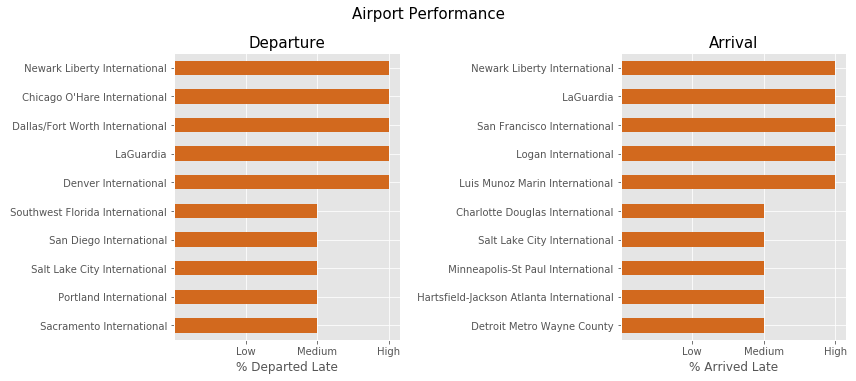

In [13]:
airport_perf = pd.concat([late_flights.sort_values("% Delayed Flight").head(), late_flights.sort_values("% Delayed Flight").tail()])
airport_perf["Category Delay"] = risk_category(airport_perf, "% Delayed Flight")
airport_perf["Category Arrive"] = risk_category(airport_perf, "% Arrived Late")


fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 5))

airport_perf.plot(kind = "barh", x = "Airport", y = "Category Delay", legend = False, ax = ax1, color = "chocolate")
ax1.set_title("Departure", fontsize = 15)
#ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_xticks([1,2,3])
ax1.set_xticklabels(["Low", "Medium", "High"])
ax1.set_ylabel("")
ax1.set_xlabel("% Departed Late")

airport_arr = pd.concat([late_flights.sort_values("% Arrived Late").head(), late_flights.sort_values("% Arrived Late").tail()])
airport_arr["Category Delay"] = risk_category(airport_arr, "% Delayed Flight")
airport_arr["Category Arrive"] = risk_category(airport_arr, "% Arrived Late")

airport_arr.plot(kind = "barh", x = "Airport", y = "Category Arrive", legend = False, ax = ax2, color = "chocolate")
ax2.set_title("Arrival", fontsize = 15)
ax2.set_xticks([1,2,3])
ax2.set_xticklabels(["Low", "Medium", "High"])
ax2.set_ylabel("")
ax2.set_xlabel("% Arrived Late")

plt.suptitle("Airport Performance", fontsize = 15, y = 1.05)
plt.tight_layout()

If you're going in or departing from Newark Liberty, you're most definitely going to have a bad time with almost 30% of their flights arrive and depart late. Best airport that's consistently great is in Salt Lake city, with percentage of late departure and arrival is just above 15%.

Note: The graph is broken down by top 10 airports, where the first 5 are the worst and the last 5 are airlines that have the least delays.

## Why does it feel like that my flights are always delayed?

In [14]:
routes = major_airlines.groupby(["ORIGIN_AIRPORT", "DEST_AIRPORT"]).agg({"ARR_DEL15":["sum", "count"]}).reset_index()
routes.columns = ["ORIGIN_AIRPORT", "DEST_AIRPORT", "DELAYED_FLIGHTS", "TOTAL_FLIGHTS"]

routes["% LATE ARRIVAL"] = routes["DELAYED_FLIGHTS"]/routes["TOTAL_FLIGHTS"]*100
routes["Arrival Category"] = risk_category(routes, "% LATE ARRIVAL")

In [15]:
print("There's only {:.2f}% of the flight routes that have a low risk of arriving late.".format(routes[routes["Arrival Category"] == 1].shape[0]/routes.shape[0]*100))

There's only 7.80% of the flight routes that have a low risk of arriving late.


In [16]:
routes[routes["TOTAL_FLIGHTS"] > 100].sort_values("% LATE ARRIVAL")[["ORIGIN_AIRPORT","DEST_AIRPORT", "% LATE ARRIVAL", "Arrival Category"]].head(10)

,ORIGIN_AIRPORT,DEST_AIRPORT,% LATE ARRIVAL,Arrival Category
937,Portland International,St Louis Lambert International,2.770083,1
327,Detroit Metro Wayne County,Sacramento International,3.289474,1
1010,Sacramento International,Austin - Bergstrom International,3.790087,1
1091,San Diego International,Los Angeles International,4.942966,1
1268,Tampa International,Salt Lake City International,5.782313,1
933,Portland International,Salt Lake City International,5.931373,1
1065,Salt Lake City International,Raleigh-Durham International,6.012658,1
1073,Salt Lake City International,Tampa International,6.462585,1
1021,Sacramento International,Hartsfield-Jackson Atlanta International,6.633166,1
245,Daniel K Inouye International,Hartsfield-Jackson Atlanta International,6.779661,1


There are over a 104 routes, about 8% of the flights, that has a low chance of arriving late. The flights listed above have less than 7% chance of arriving late.

In [19]:
print("However there's over {:.2f}% of the flight routes that have a high risk of arriving late.".format(
routes[routes["Arrival Category"] == 3].shape[0]/routes.shape[0]*100))

However there's over 42.88% of the flight routes that have a high risk of arriving late.


In [18]:
routes[routes["TOTAL_FLIGHTS"] > 100].sort_values("% LATE ARRIVAL")[["ORIGIN_AIRPORT","DEST_AIRPORT", "% LATE ARRIVAL", "Arrival Category"]].tail(10)

,ORIGIN_AIRPORT,DEST_AIRPORT,% LATE ARRIVAL,Arrival Category
597,Louis Armstrong New Orleans International,Phoenix Sky Harbor International,34.096110,3
619,Luis Munoz Marin International,Logan International,34.684685,3
719,Minneapolis-St Paul International,Newark Liberty International,34.688691,3
122,Chicago Midway International,Newark Liberty International,34.855305,3
148,Chicago O'Hare International,John F. Kennedy International,35.251799,3
246,Daniel K Inouye International,John F. Kennedy International,36.533333,3
380,George Bush Intercontinental/Houston,John F. Kennedy International,37.172775,3
795,Newark Liberty International,Sacramento International,39.147287,3
254,Daniel K Inouye International,Sacramento International,40.287770,3
626,Luis Munoz Marin International,Ronald Reagan Washington National,43.287671,3


While over 42% of the routes have over a high risk of arriving late. The flight routes listed above are the worst ones, which can go as high as 43%, Luis Munoz to Ronald Reagan Washington Airport.

I hope this helped you with getting a better airline experience!

# References:

1. [Delay Reason Descriptions](
https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations)